## MSDS 7333 Project 1 -- Predicting Location via Indoor Positioning Systems

#### Stephen Hayden, Joe Schueder, Nicole Witten, Kevin Mendonsa



### Introduction



In [17]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
onlineSummary = pd.read_csv("C:/Users/jjschued/Documents/SMU/7333 QTW/onlineSummary.csv")
offlineSummary = pd.read_csv("C:/Users/jjschued/Documents/SMU/7333 QTW/trainexport.csv")


In [18]:
offlineSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 11 columns):
Unnamed: 0           1162 non-null object
posXY                1162 non-null object
posX                 1162 non-null int64
posY                 1162 non-null int64
00:0f:a3:39:e1:c0    1162 non-null float64
00:14:bf:3b:c7:c6    1162 non-null float64
00:14:bf:b1:97:81    1162 non-null float64
00:14:bf:b1:97:8a    1162 non-null float64
00:14:bf:b1:97:8d    1162 non-null float64
00:14:bf:b1:97:90    1162 non-null float64
angle                1162 non-null int64
dtypes: float64(6), int64(3), object(2)
memory usage: 100.0+ KB


In [19]:
onlineSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 12 columns):
Unnamed: 0           60 non-null object
posXY                60 non-null object
posX                 60 non-null float64
posY                 60 non-null float64
orientation          60 non-null float64
angle                60 non-null int64
00:0f:a3:39:e1:c0    60 non-null float64
00:14:bf:3b:c7:c6    60 non-null float64
00:14:bf:b1:97:81    60 non-null float64
00:14:bf:b1:97:8a    60 non-null float64
00:14:bf:b1:97:8d    60 non-null float64
00:14:bf:b1:97:90    60 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 5.8+ KB


Here you can see that we have 40,000 non null objects one-hot encoded to include month, year, store name and alcohol type. For our previous classification analysis, we dropped the liquor category and all the liquor types and just used the binary classification for Whiskey and Non-Whiskey. With 1 representing whether the liquor type was whiskey and 0 representing a non whiskey. 

In [20]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
print(onlineSummary.shape)
onlineSummary.head()


(60, 12)


,Unnamed: 0,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0-0.05,0-0.05,0.00,0.05,130.5,135,-52.227273,-62.948980,-61.813953,-40.068966,-63.043011,-55.233333
1,0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-55.275229,-73.961905,-72.701031,-47.813084,-69.454545,-46.880000
2,0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-51.709091,-70.082474,-70.098901,-54.088235,-69.131579,-53.886598
3,0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-49.500000,-64.258065,-72.597701,-45.652893,-60.797468,-49.580000
4,0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-53.263636,-66.960000,-66.809524,-48.413793,-65.000000,-54.846939


## Modeling and Evaluation 1

Within this notebook, we have built models to evaluate classification problems.  This is a multi-classification problem in which our goal is to correctly classify  A detailed description of the metrics we will use to evaluate the models are noted below.

An ROC curve, also known as a Reciever Operation Characteristic Curve is a plot that calculates and can be used to compare the classifiers we will use in our modeling along with the true positive rate (TPR) and false positive rate (FPR) they convey. From a topline level, you can use the Area Under the Curve (AUC) to help detirmine which can better pair an observation with the correct liquor cateogry. An AUC score of 1.0 denotes a perfect classifier and an area of 0.5 represents a model is no better than a random guess.

In addition to the ROC-AUC value we will use to evaluate classifiers, we will be using other evaluators as well. 

**Accuracy** - Accuracy is the total number of correct predictions over the total number of predictions made. Accuracy will be plotted in our AUC curve and, while not perfect, is a good singlular measure to evaluate a model. Just be careful that we aren't overclassifying unbalalnced variables. 

Accuracy = (TP + TN)/(TP + FP + FN + TN)

**Precision** - Precision is the Proportions of true positives over the total number of positive outcomes whether accurately predicted or inaccurately predicted. Precision is useful to us because it will help us better understand which model is accurately picking correct classes and not resting on selecting incorrect classes. 

Precision = (TP) / (TP + FP)

**Recall** - Also known as sensitivity, recall is the proportion of positive outcomes that were correctly classified by our model. Essentially it tells us how many values we incorrectly predicted while the precision can tell us more about what we correctly classified. Recall is good as a pair with precision, as it will help us tell if our model is overfit or selecting a single class and not training itself. 

Recall/Sensitivity = (TP) / (TP + FN)

**F1 Score** - Another measure of accuracy that accounts for the true negatives and false positives. 

F1 score = 2(True Positive Rate * True Negatives)/(True Positives + True Negatives)

The aim of our modeling is to focus on maximizing our precision, recall, and accuracy scores in our models



In [42]:
#Source: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedMiddleSchoolCampuses.ipynb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)


def EvaluateClassifierEstimator(classifierEstimator, X, Y2, cv):



#Perform cross validation 
    scores = cross_validate(classifierEstimator, X, Y2,
                            scoring=['accuracy', 'precision','recall'], 
                            cv=cv, return_train_score=True, 
                            )

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Rreavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average Recall for all cv folds is: \t\t\t {Rreavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Rreavg=Rreavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    print(scoresResults)
    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, Y2, cv):
    
  #Perform cross validation 
  from sklearn.model_selection import cross_val_predict
  predictions = cross_val_predict(classifierEstimator, 
                                  X, Y2, cv=cv)
    
#model evaluation 
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#pass true test set values and predictions to classification_report
  classReport = classification_report(Y2,predictions)
  confMat = confusion_matrix(Y2,predictions)
  acc = accuracy_score(Y2,predictions)
    
  print(classReport)
  print(confMat)
  print(acc)
from imblearn.over_sampling import SMOTE    
def EvaluateClassifierEstimator3(classifierEstimator, X, Y2, cv):
  from sklearn import metrics as mt
  for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     sm = SMOTE(random_state=101)
     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     classifierEstimator.fit(X_train, y_train) 
     y_pred = classifierEstimator.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     conf = mt.confusion_matrix(y_test,y_pred)
     print("====Iteration",fold," ====")
     print("accuracy", acc )
     print("confusion matrix\n",conf)


## Modeling and Evaluation 2
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

For our first classification problem, we identified an unbalanced distribution of alcohol categories within our dataset.  For example, Vodka is 38% of sales while Rum and Whiskey is 24% and 10% respectively.  To address this concern, we used a synthetic minority oversampling technique (SMOTE).  The SMOTE technique accounts for the minority classes withn the data by creating new synthetic instances similar to these minorities.  In other words, once SMOTE is used on the data we should have a balanced distribution between the different alcohol categories. 

Futhermore, to split our test & training data, we used a stratified k-fold cross validation method.  The number of splits used was 10, and our ratio of train vs test size was 80% to 20%.

The analysis and work performed regarding the SMOTE and CV method for Classification 1 is noted below. 

NOTE:  Details regarding the training and test splits for the second classification problem can be found within the Classification 2 (Store Data) section.

So we can begin to set a baseline for our accuracy score, let's do a quick look at the value counts and it's percent distribution of our liquor categories, the ones we are looking to classify. 

In [11]:
#class percentage split
dfgrp = onlineSummary.groupby(['posXY', 'posX', 'posY'])
onlineSummary['posXY'].value_counts()
dfgrp['posXY'].count() / len(onlineSummary) *100

posXY       posX   posY 
0-0.05      0.00   0.05     1.666667
0.15-9.42   0.15   9.42     1.666667
0.31-11.09  0.31   11.09    1.666667
0.47-8.2    0.47   8.20     1.666667
0.78-10.94  0.78   10.94    1.666667
0.93-11.69  0.93   11.69    1.666667
1.08-12.19  1.08   12.19    1.666667
1.24-3.93   1.24   3.93     1.666667
1.39-6.61   1.39   6.61     1.666667
1.52-9.32   1.52   9.32     1.666667
1.55-0.96   1.55   0.96     1.666667
1.58-5.26   1.58   5.26     1.666667
1.71-1.81   1.71   1.81     1.666667
1.86-8.08   1.86   8.08     1.666667
10.23-6.88  10.23  6.88     1.666667
10.46-5.8   10.46  5.80     1.666667
10.62-3.87  10.62  3.87     1.666667
10.99-7.19  10.99  7.19     1.666667
11.39-5     11.39  5.00     1.666667
11.76-7.76  11.76  7.76     1.666667
12.16-5.25  12.16  5.25     1.666667
12.18-3.4   12.18  3.40     1.666667
12.26-6.72  12.26  6.72     1.666667
12.55-7.38  12.55  7.38     1.666667
12.95-5.25  12.95  5.25     1.666667
14.98-7.55  14.98  7.55     1.666667
16.44-7.45  1

In [12]:
onlineSummary['posXY'].value_counts()

1.24-3.93     1
23.9-7        1
9.86-3.88     1
12.55-7.38    1
0.47-8.2      1
3.44-7.43     1
21.3-3.8      1
11.76-7.76    1
2.02-7.45     1
25.23-7.78    1
16.44-7.45    1
9.46-7.77     1
1.55-0.96     1
28.12-7.57    1
11.39-5       1
26.71-7.5     1
10.62-3.87    1
1.08-12.19    1
4.51-7.63     1
0-0.05        1
1.71-1.81     1
10.46-5.8     1
1.58-5.26     1
10.99-7.19    1
31.06-7.19    1
23.24-7.5     1
22.3-6.36     1
24.31-3.89    1
21.6-7.63     1
7.48-7.36     1
0.78-10.94    1
1.52-9.32     1
10.23-6.88    1
14.98-7.55    1
22.38-3.94    1
31.78-7.62    1
1.39-6.61     1
2.49-7.6      1
8.56-7.64     1
12.16-5.25    1
0.31-11.09    1
21.45-6.62    1
23.53-4.22    1
32.16-7.08    1
0.93-11.69    1
22.76-5.06    1
25.76-7.34    1
23.36-3.4     1
1.86-8.08     1
12.18-3.4     1
12.26-6.72    1
24.7-7.7      1
21.98-7.46    1
12.95-5.25    1
32.54-7.08    1
0.15-9.42     1
21.23-5.47    1
29.58-7.93    1
9.08-7.24     1
6-7.88        1
Name: posXY, dtype: int64

In [44]:
offlineSummary['posXY'].value_counts()

2-3     7
23-8    7
26-8    7
29-7    7
22-7    7
       ..
15-8    7
23-3    7
4-7     7
2-0     7
30-8    7
Name: posXY, Length: 166, dtype: int64

So that our model is able to run correctly without having to create a large amount of additional variables, we decided to drop the Amaretto, Schnapps and Brandy values since collectively, those represent 17 observations. 

Looking at the distribution of liquors in our data_final dataset, we can see that vodka takes up 32% of the liquor sales in our set, followed by Rum at 13%, Liquer at 13%, Whisky at 22% and so on. When we run our classifier, we will need to be careful to account for the unbalanced nature of our classifiers to help ensure we aren't overclassifying the majority labels. 

For our data training, we will need to employ synthetic minority oversampling technique (SMOTE), which is designed to subset our data from the minority classes as an example with new synthetic instances similar to these minorities are created and added to a new data set which we will use as a train to our classification models. 

But first, we will assign our X and Y variables and a stratified Kfold to evaluate our meotrics. The reason we want to do a stratified k-fold is because it will test our model multiple times using different splits of the data and different testing groups. The average at the end will help us get an accurate score of how strong our model is and accounts for any skewness in the data that was not captured in the transform. 

We think this is most appropriate since we've transformed our data, so we should get minimal outlier skew, and we will have an aggredate score of accuracy, precision and recall based on different groupings of the data.

In [13]:
onlineSummary.columns

Index(['Unnamed: 0', 'posXY', 'posX', 'posY', 'orientation', 'angle',
       '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81',
       '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90'],
      dtype='object')

In [21]:
offlineSummary.columns

Index(['Unnamed: 0', 'posXY', 'posX', 'posY', '00:0f:a3:39:e1:c0',
       '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81', '00:14:bf:b1:97:8a',
       '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90', 'angle'],
      dtype='object')

In [16]:
onlineSummary.head()

,Unnamed: 0,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0-0.05,0-0.05,0.00,0.05,130.5,135,-52.227273,-62.948980,-61.813953,-40.068966,-63.043011,-55.233333
1,0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-55.275229,-73.961905,-72.701031,-47.813084,-69.454545,-46.880000
2,0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-51.709091,-70.082474,-70.098901,-54.088235,-69.131579,-53.886598
3,0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-49.500000,-64.258065,-72.597701,-45.652893,-60.797468,-49.580000
4,0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-53.263636,-66.960000,-66.809524,-48.413793,-65.000000,-54.846939


In [58]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['angle',
       '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81',
       '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90']

X2 = offlineSummary[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)
X = offlineSummary[features].copy()
Y= offlineSummary[['posXY']].copy()
Y2 = Y.values

#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)

Wall time: 8.37 ms


#### Feature Engineering: SMOTE

Now that we built our cross validation and assigned Xs and Ys, we will now work to create our training set and test set using SMOTE to balance our classifiers. Training size was 80% of our data and the test size was 20%. 

In [59]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101) 


## Classification Task 1 (Liquor Type)





### Task 1 - Modeling and Evaluation 3
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!  

As previously mentioned within a section above, our goal of this classification problem is to correctly classify the alcohol category based on sales data.  We tried 3 different algorithms within our models and compared them using our evaluation metrics.  The algorithms used are as follows:  

*   K-Nearest Neighbor
*   Random Forest Classification
*   Logistic Regression

A ROC/AUC plot will be created for each model and summarized our findings based on the combined results for these different models.

#### Model 1: KNN Classification

Details regarding this model are noted in the code below, but to quickly summarize, this model has an average accuracy score of 0.58 and a Precision, Recall, & F1 Score of 0.91, 0.91, & 0.91 respectively.  After evaluation this is not our best fitting model.

Initially, it looks like this but after our cross validation, but details on our model are outlined below in the code. 

In [70]:

param_grid = [
    {
         'weights': ['uniform','distance'],
         'leaf_size': [5,10],
         'metric': ['minkowski','euclidean', 'manhattan'],
         'n_neighbors':[2,3,5, 6,7],
         
    }
]

clf_KNN = KNeighborsClassifier()
grid_search_KNN = GridSearchCV(clf_KNN, param_grid=param_grid,cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

KNearest_model1 = grid_search_KNN.fit(X1_train, y1_train)

y_KNN_score1 = KNearest_model1.predict(X1_test)



Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished


Our first modeling procedure we ran was a KNN classification. Detail on the concept behind it can be found below, but on this particular version, we are using our smote engineered features to fit the model and running a grid search procedure to select the best hyperparameter. 

In [71]:
classifierEstimaterKNN1 = KNearest_model1.best_estimator_
classifierEstimaterKNN1


KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

According to our grid search, the best estimator is to include 5 neighbors, a leaf size of 10 and a minkowski metric to learn from. 

In [0]:
#import pickle
#filename = r'C:/Users/jjsch/Documents/GitHub/7331lab1/7331DataMiningNotebooks/lab2/classifierEstimaterKNN1.pickle'
#infile = open(filename,'rb')
#classifierEstimaterKNN1 = pickle.loads(infile)
#infile.close()
#outfile = open(filename,'wb')
#pickle.dumps(classifierEstimaterKNN1, filename)
#from joblib import dump, load
#dump(classifierEstimaterKNN1, filename)

In [72]:
y_KNN_score1 = classifierEstimaterKNN1.predict(X1_test)
y_KNN_score1

array(['1-12', '5-7', '22-7', '10-4', '2-7', '31-7', '21-4', '21-8',
       '12-4', '12-3', '11-7', '26-7', '10-4', '10-6', '22-7', '28-7',
       '0-13', '1-4', '19-7', '18-8', '0-3', '21-3', '13-4', '2-12',
       '1-10', '17-8', '28-7', '6-3', '15-7', '32-3', '1-0', '0-0', '1-8',
       '24-8', '24-4', '24-4', '24-4', '0-3', '1-4', '29-7', '9-3',
       '0-10', '22-7', '2-1', '6-3', '0-1', '1-10', '30-3', '6-3', '26-8',
       '5-7', '13-7', '11-8', '24-4', '0-10', '5-8', '1-6', '25-8',
       '31-3', '31-7', '11-3', '21-4', '15-8', '18-7', '18-7', '7-8',
       '12-8', '16-7', '6-8', '21-4', '2-10', '1-10', '23-3', '30-8',
       '27-3', '12-8', '0-9', '0-9', '31-7', '21-4', '10-8', '15-7',
       '21-5', '22-4', '10-4', '5-3', '0-9', '11-7', '30-7', '4-3',
       '11-3', '7-7', '28-8', '12-4', '31-7', '15-3', '0-8', '24-6',
       '19-8', '10-4', '23-6', '22-5', '21-6', '5-8', '1-12', '7-8',
       '0-12', '6-3', '10-7', '1-11', '15-3', '0-9', '12-5', '10-7',
       '22-6', '0-0',

In [73]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Precision Score is: {}" .format(precision_score(y1_test, y_KNN_score1, average='weighted')))
print("Recall Score is: {}" .format(recall_score(y1_test, y_KNN_score1, average='weighted')))
print("F1 Score is: {}" .format(f1_score(y1_test, y_KNN_score1, average='weighted')))

Precision Score is: 0.0
Recall Score is: 0.0
F1 Score is: 0.0


In [94]:
y1_test

,0,1
1067,2,11
652,6,7
931,23,7
210,13,3
295,3,7
...,...,...
787,28,7
806,32,8
524,10,3
333,0,1


In [93]:
y1_test = y1_test['posXY'].str.split("-", n = 1, expand = True)

In [95]:
yscore = pd.DataFrame(y_KNN_score1)

In [96]:
yscore=yscore[0].str.split("-", n = 1, expand = True)

In [138]:
y1_test

,0,1
1067,2,11
652,6,7
931,23,7
210,13,3
295,3,7
...,...,...
787,28,7
806,32,8
524,10,3
333,0,1


In [139]:
y1_test = y1_test.reset_index()
y1_test.index

RangeIndex(start=0, stop=233, step=1)

Text(0.5,1,'Actual and predicted values')

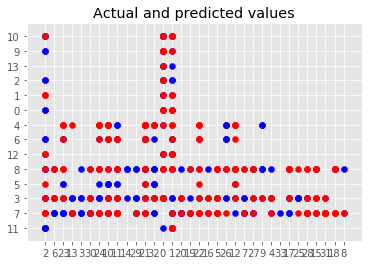

In [189]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.scatter(y1_test[0], y1_test[1], c = 'blue', label = 'Actual')
plt.scatter(yscore[0], yscore[1], c = 'red', label = 'Predicted')


plt.title('Actual and predicted values')
plt.title('Actual and predicted values')

In [267]:
ygroup2 = y1_test.reset_index()
ygroup2 = pd.merge(ygroup2, yscore, left_index=True, right_index=True)
ygroup2


,level_0,index,0_x,1_x,0_y,1_y
0,0,1067,2,11,1,12
1,1,652,6,7,5,7
2,2,931,23,7,22,7
3,3,210,13,3,10,4
4,4,295,3,7,2,7
...,...,...,...,...,...,...
228,228,787,28,7,27,8
229,229,806,32,8,31,7
230,230,524,10,3,10,4
231,231,333,0,1,0,0


In [268]:

ygroup2['0_x'] = ygroup2['0_x'].astype(float) 
ygroup2['1_x'] = ygroup2['1_x'].astype(float) 
ygroup2['0_y'] = ygroup2['0_y'].astype(float) 
ygroup2['1_y'] = ygroup2['1_y'].astype(float) 
ygroup2['xdist'] = ygroup2['0_x'] - ygroup2['0_y']
ygroup2['ydist'] = ygroup2['1_x'] - ygroup2['1_y']
ygroup2['obatuple'] = ygroup2[['0_x', '1_x']].apply(tuple, axis=1)
ygroup2['obttuple'] = ygroup2[['0_y', '1_y']].apply(tuple, axis=1) 

In [269]:
ygroup2['xsqr'] = (ygroup2['0_x'] - ygroup2['0_y'])**2
ygroup2['ysqr'] = (ygroup2['1_y'] - ygroup2['1_y'])**2

In [270]:
ygroup2['distance'] = ygroup2['xsqr'] + ygroup2['ysqr']

In [271]:
ygroup2['distancefinalerror'] = np.sqrt(ygroup2['distance'])

In [272]:
ygroup2

,level_0,index,0_x,1_x,0_y,1_y,xdist,ydist,obatuple,obttuple,xsqr,ysqr,distance,distancefinalerror
0,0,1067,2.0,11.0,1.0,12.0,1.0,-1.0,"(2.0, 11.0)","(1.0, 12.0)",1.0,0.0,1.0,1.0
1,1,652,6.0,7.0,5.0,7.0,1.0,0.0,"(6.0, 7.0)","(5.0, 7.0)",1.0,0.0,1.0,1.0
2,2,931,23.0,7.0,22.0,7.0,1.0,0.0,"(23.0, 7.0)","(22.0, 7.0)",1.0,0.0,1.0,1.0
3,3,210,13.0,3.0,10.0,4.0,3.0,-1.0,"(13.0, 3.0)","(10.0, 4.0)",9.0,0.0,9.0,3.0
4,4,295,3.0,7.0,2.0,7.0,1.0,0.0,"(3.0, 7.0)","(2.0, 7.0)",1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,228,787,28.0,7.0,27.0,8.0,1.0,-1.0,"(28.0, 7.0)","(27.0, 8.0)",1.0,0.0,1.0,1.0
229,229,806,32.0,8.0,31.0,7.0,1.0,1.0,"(32.0, 8.0)","(31.0, 7.0)",1.0,0.0,1.0,1.0
230,230,524,10.0,3.0,10.0,4.0,0.0,-1.0,"(10.0, 3.0)","(10.0, 4.0)",0.0,0.0,0.0,0.0
231,231,333,0.0,1.0,0.0,0.0,0.0,1.0,"(0.0, 1.0)","(0.0, 0.0)",0.0,0.0,0.0,0.0


In [273]:
ygroup2['distancefinalerror'].mean()

1.5665236051502145

In [283]:
ygroup2['obatuple']

0      (2.0, 11.0)
1       (6.0, 7.0)
2      (23.0, 7.0)
3      (13.0, 3.0)
4       (3.0, 7.0)
          ...     
228    (28.0, 7.0)
229    (32.0, 8.0)
230    (10.0, 3.0)
231     (0.0, 1.0)
232     (2.0, 2.0)
Name: obatuple, Length: 233, dtype: object

In [ ]:
wholelist = []
for i, row in ygroup2.iterrows():
    print(i)
    row['obatuple']
    rowlist = []
    rowlist.append(row['obatuple'])
    rowlist.append(row['obatuple'])
    wholelist.append(rowlist)
    print(rowlist)
print(wholelist)    

In [291]:
listr = [wholelist[0]]
type(listr)
#listr[1]
#type(listr[1])

wholelist[0]
listr


[[(2.0, 11.0), (2.0, 11.0)]]

In [315]:
x1, x2, y1, y2 = None,None,None,None

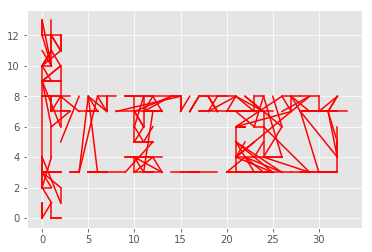

In [316]:
for i, row in ygroup2.iterrows():
    x1, x2 = ygroup2.loc[i,'0_x'], ygroup2.loc[i,'0_y']
    y1, y2 = ygroup2.loc[i,'1_x'], ygroup2.loc[i,'1_y']
    plt.plot([x1,x2],[y1,y2],'k-', color='red')


After Running our procedure, we were able get garner a very strong precision, recall and F1 score. which was very high. These scores are strong supporters in accuracy in that it helps test whether a model is truly trying to predict a value rather than selecting a single value. 

In [45]:
classifierEstimaterKNN1.fit(X1_train,y1_train)



KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')

#### Model 2: Random Forest Classification

Details regarding this model are noted in the code below, but to quickly summarize, this model has an average accuracy score of 0.67 and a Precision, Recall, & F1 Score of 0.93, 0.93, & 0.93 respectively.  After cross evaluation there was more factors to be detirmined from the output of our code below. 

In [251]:
param_grid = [
    {
         'n_estimators': [200, 500], 
         'max_depth': [20,30,35],
         'random_state':[101]
     }
]

clf_RF = RandomForestClassifier()
grid_search_RF = GridSearchCV(clf_RF, param_grid=param_grid, cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

RandomForest_model1 = grid_search_RF.fit(X1_train, y1_train)

y_RF_score1 = grid_search_RF.predict(X1_test)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   14.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   16.0s finished


In [255]:
yrfscore = pd.DataFrame(y_RF_score1)
yrfscore=yrfscore[0].str.split("-", n = 1, expand = True)

In model 2, we ran a Random Forest Classification procedure to classify liquor types. You can learn more in the documentation below. 

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

Like the KNN model before, we decided to run a grid search procedure as well to help us find the optimal hyperparameters to tune to. 

In [0]:
classifierEstimaterRF1 = RandomForest_model1.best_estimator_
classifierEstimaterRF1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

After running our Random Forest procedure, we can see the grid search selected, a max depth of 20, a number of estimators split of 500 and no warm start with our model. 

In [274]:
ygroup3 = y1_test.reset_index()
ygroup3 = pd.merge(ygroup3, yrfscore, left_index=True, right_index=True)
ygroup3['obatuple'] = ygroup3[['0_x', '0_y']].apply(tuple, axis=1)
ygroup3['obttuple'] = ygroup3[['1_x', '1_y']].apply(tuple, axis=1)
ygroup3['0_x'] = ygroup3['0_x'].astype(float) 
ygroup3['1_x'] = ygroup3['1_x'].astype(float) 
ygroup3['0_y'] = ygroup3['0_y'].astype(float) 
ygroup3['1_y'] = ygroup3['1_y'].astype(float) 
ygroup3['xdist'] = ygroup3['0_x'] - ygroup3['0_y']
ygroup3['ydist'] = ygroup3['1_x'] - ygroup3['1_y']
ygroup3['xsqr'] = (ygroup3['0_x'] - ygroup3['0_y'])**2
ygroup3['ysqr'] = (ygroup3['1_y'] - ygroup3['1_y'])**2
ygroup3['distance'] = ygroup3['xsqr'] + ygroup3['ysqr']
ygroup3['distancefinalerror'] = np.sqrt(ygroup3['distance'])

ygroup3['obatuple'] = ygroup3[['0_x', '1_x']].apply(tuple, axis=1)
ygroup3['obttuple'] = ygroup3[['0_y', '1_y']].apply(tuple, axis=1) 
ygroup3

,level_0,index,0_x,1_x,0_y,1_y,obatuple,obttuple,xdist,ydist,xsqr,ysqr,distance,distancefinalerror
0,0,1067,2.0,11.0,2.0,11.0,"(2.0, 11.0)","(2.0, 11.0)",0.0,0.0,0.0,0.0,0.0,0.0
1,1,652,6.0,7.0,7.0,7.0,"(6.0, 7.0)","(7.0, 7.0)",-1.0,0.0,1.0,0.0,1.0,1.0
2,2,931,23.0,7.0,23.0,8.0,"(23.0, 7.0)","(23.0, 8.0)",0.0,-1.0,0.0,0.0,0.0,0.0
3,3,210,13.0,3.0,13.0,3.0,"(13.0, 3.0)","(13.0, 3.0)",0.0,0.0,0.0,0.0,0.0,0.0
4,4,295,3.0,7.0,3.0,7.0,"(3.0, 7.0)","(3.0, 7.0)",0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,228,787,28.0,7.0,28.0,8.0,"(28.0, 7.0)","(28.0, 8.0)",0.0,-1.0,0.0,0.0,0.0,0.0
229,229,806,32.0,8.0,33.0,8.0,"(32.0, 8.0)","(33.0, 8.0)",-1.0,0.0,1.0,0.0,1.0,1.0
230,230,524,10.0,3.0,10.0,3.0,"(10.0, 3.0)","(10.0, 3.0)",0.0,0.0,0.0,0.0,0.0,0.0
231,231,333,0.0,1.0,1.0,5.0,"(0.0, 1.0)","(1.0, 5.0)",-1.0,-4.0,1.0,0.0,1.0,1.0


In [275]:
ygroup3['distancefinalerror'].mean()

0.9484978540772532

In [276]:
ygroup3['distancefinalerror'].sum()

221.0

Text(0.5,1,'Actual and predicted values')

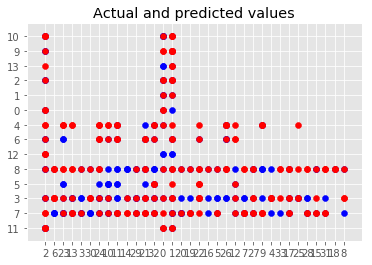

In [277]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.scatter(y1_test[0], y1_test[1], c = 'blue', label = 'Actual')
plt.scatter(yrfscore[0], yrfscore[1], c = 'red', label = 'Predicted')


plt.title('Actual and predicted values')
plt.title('Actual and predicted values')

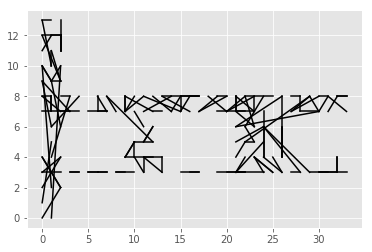

In [324]:
for i, row in ygroup3.iterrows():
    x1, x2 = ygroup3.loc[i,'0_x'], ygroup3.loc[i,'0_y']
    y1, y2 = ygroup3.loc[i,'1_x'], ygroup3.loc[i,'1_y']
    plt.plot([x1,x2], [y1,y2],'k-')